# Predicting Rents in Berlin, Germany

# Contents

* [Overview](#overview)
* [Data Preprocessing](#data_preprocessing)
* [Exploratory Data Analysis](#exploratory_data_analysis)
* [Feature Engineering](#feature_engineering)
* [Modeling](#modeling)
* [Evaluation](#evaluation)
* [Limitations](#limitations)
* [Summary](#summary)
* [References](#references)

# Overview <a id='overview'></a>

## Project Objective

The objective of this project is to predict the monthly rent prices of real estate objects in the capital city Berlin of the country Germany. Thereby, the rent prices are given in the currency €. The prediction outcome of such a model enables landlords and tenants to appropriately estimate the rent of a given property. In addition to a more precise estimation of the rent, the determination of the rent is also accelerated in order to advertise the object on real estate platforms.

## Dataset

The dataset **Apartment rental offers in Germany** is provided by the data science community platform Kaggle and consists originally of 268,850 observations and 49 feature columns. All observations were scraped from Immoscout24 which is one of the biggest real estate platforms in Germany. Although the platform Immoscout24 offers both home for sales and rental properties, the dataset only contains the rental properties of the 16 states and their corresponding districts of Germany. In this project, only the state Berlin as the capital city of Germany is considered in order to reduce the amount of data and to investigate the prediction performance of one single city. Therefore, the used dataset was prepared by filtering and selecting the state Berlin which resulted in 10,406 observations and 49 feature columns. The features contain most of the important properties such as living area, location (state, zip code, district, street, house number, etc), energy type, condition, kitchen, number of rooms, rent and so on.

The original dataset can be found [here](https://www.kaggle.com/corrieaar/apartment-rental-offers-in-germany) where you also can find more information about the scraping process [1].

## Target Feature

The target feature is the `base_rent` which is a continuous numerical feature and hence represents a regression problem with numerical response. The choice of the base rent as target depends on the fact that this feature is very stable and does not depend on many other variable features such as the electricity costs as this is the case for the total rent.

## Methodology

Before we search for an appropriate model for predicting the base rent of a given observation, the dataset is preprocessed by considering irrelevant features, missing values and outliers. Furthermore, we create new features during the feature engineering process in order to add some meaningful descriptive features. After these steps, we consider the following regression models to predict the target feature `base_rent`:

- Decision Tree (DT)
- Support Vectore Machine (SVM)
- Gradient Boosting (GB)

First of all, the cleaned dataset is prepared by performing one-hot-encoding and integer-encoding on the categorical descriptive features. The strategy one-hot-encoding is used for the nominal descriptive features and the integer-encoding for the ordinal descriptive features to keep the information about the natural order. Subsequently, we randomly sample 5000 observations in order to reduce the required time for the learning process of the models. The sampled dataset will be splitted into a train and test dataset with the test ratio of 30% to minimize overfitting. This results into 3500 observations for the training phase and 1500 observations for the testing phase. All considered models are wrapped into the `TransformedTargetRegressor` class of `sklearn` to enable the normalization of the target feature base rent. This class normalizes the target feature by a given transformation function before the learning process and transforms the prediction results back by a given inverse function.

The optimal model hyperparameters are identified by applying a gridsearch for each model pipeline in a 5-fold cross-validation fashion using the negative mean absolute error as scoring function. Each pipeline also includes a standard scaling of the descriptive features and the feature selection strategy `SelectKBest` by considering the mutual information for regression tasks. The regression models with their best hyperparameters are compared on the test dataset using 10-fold cross-validation in a paired fashion. The performance differences are investigated by paired t-tests to identify the statistically significance [2]. For comparison, the mean absolute error is used as this scoring method is good interpretable regarding the rent prices in €.

# Data Preprocessing  <a id='data_preprocessing'></a>

### Imports

In [1]:
# Ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# Display all columns of DataFrame
pd.set_option('display.max_columns', None) 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

In [2]:
from sklearn import feature_selection as fs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

In [3]:
# Required for t-tests
from scipy import stats

In [4]:
# Set seed for reproducibility
seed = 999
np.random.seed(seed)

### Helper Methods

In [5]:
# Counts the amount of words within a text and returns an integer.
def text_to_word_count(text):
    import re
    text = re.split(' |\n|\t', text)
    words = list(filter(None, text))
    return len(words)

In [6]:
# Reference: [2]
# Custom function to format the search results as a Pandas data frame.
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
                  'std_score': np.std(scores),
                  'min_score': np.min(scores),
                  'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = []
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]

### Loading the Dataset

Firstly, we load the prepared dataset which only contains the observations for the state Berlin.

In [7]:
rents = pd.read_csv('data/rents_berlin.csv')
rents.shape

(10406, 49)

The dataset contains 10,406 observations and 49 feature columns including the target feature. Let's have a look at five randomly selected samples to get an intuition about the dataset. 

In [8]:
rents.sample(n=5, random_state=seed)

,state,ancillary_costs,heating_type,telekom_tv_offer,telekom_hybrid_upload_speed,new_construction,balcony,num_pictures,price_trend,telekom_upload_speed,total_rent,construction_year,immoscout_id,num_parking_spaces,firing_type,kitchen,geo_state,cellar,construction_year_range,base_rent,house_number,living_area,geo_district,condition,interior_quality,pets,street,street_plain,elevator,base_rent_range,flat_type,geo_zip,num_rooms,energy_demand,floor,num_floors,num_rooms_range,garden,living_area_range,city,city_district,description,facilities_description,heating_costs,energy_efficiency_class,last_refurbish,electricity_base_price,electricity_kwh_price,date
5751,Berlin,426.00,NaN,ONE_YEAR_FREE,10.0,False,True,19,6.83,2.4,2416.00,1906.0,113119651,NaN,steam_district_heating,True,Berlin,True,1.0,1990.00,89,209.00,Berlin,fully_renovated,sophisticated,NaN,Kaiserdamm,Kaiserdamm,True,8,roof_storey,14057,5.0,NaN,5.0,5.0,5,False,7,Berlin,Charlottenburg_Charlottenburg,"Diese ansprechende, vollständig renovierte Dac...",Eichenparkett,NaN,NaN,2008.0,NaN,NaN,Oct-19
7411,Berlin,88.60,central_heating,ONE_YEAR_FREE,NaN,True,True,21,7.08,40.0,649.52,2019.0,113766700,NaN,gas,True,Berlin,True,9.0,560.92,53a,28.24,Berlin,first_time_use,sophisticated,NaN,Einbecker Str.,Einbecker_Str.,True,4,apartment,10315,1.0,23.3,NaN,4.0,1,False,1,Berlin,Friedrichsfelde_Lichtenberg,Neues Wohnen in Lichtenberg/Weitlingkiez\n\nHi...,Wohnbeispiel eines 1 Zimmer Apartments: \n\n1 ...,50.00,B,NaN,NaN,NaN,Oct-19
2056,Berlin,250.00,central_heating,ONE_YEAR_FREE,NaN,False,False,21,7.53,10.0,1350.00,1900.0,115649903,NaN,district_heating,True,Berlin,True,1.0,1100.00,22,51.00,Berlin,refurbished,normal,no,Simon-Dach-Str.,Simon-Dach-Str.,False,7,NaN,10245,2.0,NaN,3.0,NaN,2,False,2,Berlin,Friedrichshain_Friedrichshain,Sanierte und voll möblierte 2 Zimmer Altbau-Wo...,Ruhige 2-Zimmer-Altbauwohnung im 1. Seitenflüg...,125.00,NaN,NaN,NaN,NaN,Feb-20
5010,Berlin,152.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,12,10.09,40.0,1150.00,1903.0,107335290,NaN,gas,False,Berlin,False,1.0,998.00,14,56.00,Berlin,fully_renovated,normal,negotiable,Hausburgstra&szlig;e,Hausburgstraße,False,6,apartment,10249,2.0,114.0,3.0,4.0,2,False,2,Berlin,Friedrichshain_Friedrichshain,Wir bieten Ihnen eine frisch renovierte und mö...,"Die voll eingerichtete Küche mit Kühlschrank, ...",NaN,D,NaN,90.76,0.1985,Sep-18
551,Berlin,202.76,district_heating,ONE_YEAR_FREE,NaN,False,True,5,7.88,40.0,957.31,1960.0,115694160,NaN,district_heating,False,Berlin,False,2.0,754.55,122,59.46,Berlin,first_time_use_after_refurbishment,NaN,NaN,Alexandrinenstr.,Alexandrinenstr.,True,5,apartment,10969,2.0,145.1,4.0,NaN,2,False,2,Berlin,Kreuzberg_Kreuzberg,Das Objekt wurde kürzlich vollständig saniert....,Unsere schöne Wohnung wurde für Sie umfangreic...,66.06,NaN,NaN,NaN,NaN,Feb-20


We can see that our target feature is named as `base_rent` and the dataset consists of a mixture of categorical and continuous descriptive features. Moreover, we can already see some `NaN` values which represents missing values within our dataset. The feature `date` seems to be a time component but we won't consider this in the following processing steps.

### Summary Statistics

Let's create the summary statistics of the categorical and continuous features to get an overview about values such as count, cardinality, mode and frequency for categorical features as well as mean, standard deviation and quartiles for continiuous features.

In [9]:
rents.describe(include=[np.object, np.bool])

,state,heating_type,telekom_tv_offer,new_construction,balcony,firing_type,kitchen,geo_state,cellar,house_number,geo_district,condition,interior_quality,pets,street,street_plain,elevator,flat_type,garden,city,city_district,description,facilities_description,energy_efficiency_class,date
count,10406,8935,8994,10406,10406,8122,10406,10406,10406,8879,10406,8138,6198,5568,10406,8879,10406,9602,10406,10406,10406,9742,9083,3489,10406
unique,1,13,3,2,2,37,2,1,2,878,1,9,4,3,3270,3362,2,10,2,1,79,7380,7397,10,4
top,Berlin,central_heating,ONE_YEAR_FREE,False,True,district_heating,True,Berlin,True,19,Berlin,first_time_use,sophisticated,negotiable,no_information,Heidestraße,False,apartment,False,Berlin,Mitte_Mitte,Wichtig: Bitte lassen Sie uns eine Kontaktanfr...,#NAME?,B,May-19
freq,10406,4129,8952,8739,7611,3802,6162,10406,5589,276,10406,1774,3490,4027,1527,176,5376,6565,8955,10406,805,87,544,784,2869


In [10]:
rents.describe(include=np.number)

,ancillary_costs,telekom_hybrid_upload_speed,num_pictures,price_trend,telekom_upload_speed,total_rent,construction_year,immoscout_id,num_parking_spaces,construction_year_range,base_rent,living_area,base_rent_range,geo_zip,num_rooms,energy_demand,floor,num_floors,num_rooms_range,living_area_range,heating_costs,last_refurbish,electricity_base_price,electricity_kwh_price
count,10171.000000,918.0,10406.000000,10381.000000,8993.000000,9744.000000,8981.000000,1.040600e+04,2013.000000,8981.000000,10406.000000,10406.000000,10406.000000,10406.000000,10406.000000,7131.000000,9306.000000,7279.000000,10406.000000,10406.000000,5637.000000,3336.000000,1995.000000,1995.000000
mean,199.041765,10.0,11.607534,7.866659,32.195063,1385.341741,1965.192072,1.091173e+08,1.993542,4.207883,1165.311461,81.817844,5.962041,11931.822122,2.565520,111.318516,2.846658,4.830196,2.499616,3.374880,86.020028,2016.644784,90.750311,0.198515
std,168.043754,0.0,7.529810,1.608934,13.845960,1129.695296,49.557871,9.891847e+06,5.047730,3.253247,885.215276,44.094348,1.936275,1337.383735,1.461288,53.464081,2.769182,2.301299,1.035808,1.642264,55.782683,4.921149,0.432773,0.000652
min,0.000000,10.0,0.000000,3.570000,1.000000,0.000000,1097.000000,3.037401e+07,0.000000,1.000000,0.000000,3.000000,1.000000,10017.000000,1.000000,0.460000,-1.000000,0.000000,1.000000,1.000000,0.000000,1903.000000,71.430000,0.198500
25%,110.000000,10.0,7.000000,6.640000,40.000000,790.000000,1911.000000,1.073500e+08,1.000000,1.000000,635.877500,55.600000,5.000000,10557.000000,2.000000,73.900000,1.000000,4.000000,2.000000,2.000000,55.000000,2016.000000,90.760000,0.198500
50%,164.950000,10.0,10.000000,7.780000,40.000000,1124.000000,1978.000000,1.113782e+08,1.000000,3.000000,945.000000,72.000000,6.000000,12207.000000,2.000000,104.700000,2.000000,5.000000,2.000000,3.000000,75.140000,2018.000000,90.760000,0.198500
75%,240.000000,10.0,15.000000,8.890000,40.000000,1685.217500,2015.000000,1.138342e+08,1.000000,8.000000,1442.002500,97.000000,7.000000,13125.000000,3.000000,140.400000,4.000000,6.000000,3.000000,4.000000,104.000000,2019.000000,90.760000,0.198500
max,6500.000000,10.0,89.000000,12.870000,100.000000,51570.000000,2029.000000,1.157116e+08,58.000000,9.000000,20000.000000,566.000000,9.000000,19437.000000,99.500000,1555.000000,83.000000,27.000000,5.000000,7.000000,1200.000000,2020.000000,90.760000,0.227600


Since the unique values of the features `state`, `geo_state`, `geo_district` and `city` resulting in 1, we can remove this columns later from our dataset as this features won't contribute to the prediction of our target feature. However, this values were expected because we just consider the state **Berlin** of the original dataset and these features are related to the location within the country Germany. Furthermore, some counts are different from the amount of observations (10,406) and hence indicates a lot of missing values for some specific features.

Regarding the continuous features, some minimum values, maximum values and standard deviations are suspicious. For example, the target feature `base_rent` is in the range between 0 and 20000€ which indicates implausible values and outliers. This also applies for other features such as `num_rooms`, `num_parking_spaces`, `ancillary_costs` and `total_rent`. At last, the name of the feature `immoscout_id` already indicates that this column represents the id of the platform entry and `geo_zip` the city district of the offer.

### Handling Irrelevant Features and Missing Values

Before we start with the data preprocessing steps for the various features, we need to remove id-like columns as well as irrelevant and redundant features. The following features will be removed before continuing with further data preprocessing steps:

- `immscout_id`
> This feature represents an id-like column.
- `state`, `geo_state`, `geo_district`, `city`
> This features have only the cardinality of 1.
- `geo_zip`, `base_rent_range`, `construction_year_range`, `num_rooms_range`, `living_area_range`, `firing_type`
> This features are redundant due to same information as other features or are based on other features.
- `street_plain`, `house_number`, `telekom_tv_offer`, `telekom_hybrid_upload_speed`, `telekom_upload_speed`, `last_refurbish`
> This features are irrelevant which can lead to high dimensionality in our final training dataset.
- `price_trend`, `ancillary_costs`, `total_rent`, `heating_costs`, `electricity_base_price`, `electricity_kwh_price`
> This features are irrelevant since we want to predict the base rent and all of them contribute to the total rent.
- `date`
> Remove the time component of the dataset.

In [11]:
features_to_drop = ['immoscout_id', 'state', 'city', 'geo_state', 'geo_district', 'geo_zip', 'street', 
                    'street_plain', 'house_number', 'telekom_tv_offer', 'telekom_hybrid_upload_speed',
                    'telekom_upload_speed', 'price_trend', 'base_rent_range', 'construction_year_range', 
                    'num_rooms_range', 'ancillary_costs', 'total_rent', 'living_area_range', 'heating_costs', 
                    'last_refurbish', 'electricity_base_price', 'electricity_kwh_price', 'firing_type',
                    'date']

rents.drop(columns=features_to_drop, inplace=True)
rents.shape

(10406, 24)

As next step, we check the values of all categorical features to see if some suspicious values are leading to irregular cardinalities or indicate missing values. This can happen if the dataset contains a mixture of lowercase and uppercase strings or unintended whitespaces.

In [12]:
for col in rents.columns:
    if rents[col].dtype == np.object:
        print(col)
        print(rents[col].unique())
        print()

heating_type
['central_heating' 'floor_heating' 'district_heating'
 'combined_heat_and_power_plant' 'gas_heating'
 'self_contained_central_heating' nan 'oil_heating' 'wood_pellet_heating'
 'solar_heating' 'heat_pump' 'night_storage_heater' 'electric_heating'
 'stove_heating']

condition
[nan 'refurbished' 'first_time_use' 'mint_condition' 'modernized'
 'first_time_use_after_refurbishment' 'well_kept' 'fully_renovated'
 'need_of_renovation' 'negotiable']

interior_quality
[nan 'luxury' 'sophisticated' 'normal' 'simple']

pets
['negotiable' 'no' nan 'yes']

flat_type
['ground_floor' 'apartment' 'maisonette' 'roof_storey' 'penthouse'
 'raised_ground_floor' 'terraced_flat' 'other' nan 'loft' 'half_basement']

city_district
['Staaken_Spandau' 'Weißensee_Weißensee' 'Mitte_Mitte'
 'Kreuzberg_Kreuzberg' 'Tiergarten_Tiergarten' 'Grünau_Köpenick'
 'Marzahn_Marzahn' 'Köpenick_Köpenick'
 'Neu_Hohenschönhausen_Hohenschönhausen' 'Hellersdorf_Hellersdorf'
 'Prenzlauer_Berg_Prenzlauer_Berg' 'Französis

The feature `energy_efficiency_class` contains the value "NO_INFORMATION" and can be interpreted as missing value. Therefore, each of these values are replaced by a missing value.

In [13]:
rents['energy_efficiency_class'].replace({'NO_INFORMATION': np.nan}, inplace=True)

Now we can check all missing values within our dataset.

In [14]:
rents.isnull().sum()

heating_type               1471
new_construction              0
balcony                       0
num_pictures                  0
construction_year          1425
num_parking_spaces         8393
kitchen                       0
cellar                        0
base_rent                     0
living_area                   0
condition                  2268
interior_quality           4208
pets                       4838
elevator                      0
flat_type                   804
num_rooms                     0
energy_demand              3275
floor                      1100
num_floors                 3127
garden                        0
city_district                 0
description                 664
facilities_description     1323
energy_efficiency_class    7561
dtype: int64

The missing values are treated for each feature as follows:

- `heating_type`: Imputing central_heating as this type of heating is most common (~46%).
- `construction_year`: Imputing the median of the construction year.
- `num_parking_spaces`: Drop this column as over 80% values are missing.
- `condition`: Imputing of undefined as the mode is not significantly high.
- `interior_quality`: Imputing sophisticated as this type of quality is most common (~56%).
- `pets`: Imputing negotiable as this type is most common (~72%).
- `flat_type`: Imputing apartments as this type of flat is most common (~68%).
- `energy_demand`: Imputing the median of the energy demand.
- `floor`: Imputing 1 as this floor is most common.
- `num_floors`: Imputing the mode 5 as this number of floors is most common.
- `energy_efficiency_class`: Imputing of undefined as the mode is not significantly high.
- `description`: Imputing of a empty string.
- `facilities_description`: Imputing of a empty string.

In [15]:
features_cat_undefined = ['condition', 'energy_efficiency_class']
features_cat_mode = ['heating_type', 'interior_quality', 'pets', 'flat_type', 'floor', 'num_floors']
features_cat_empty_string = ['description', 'facilities_description']
features_con_median = ['energy_demand', 'construction_year']

for col in features_cat_undefined:
    rents[col] = rents[col].fillna('undefined')
    
for col in features_cat_mode:
    rents[col] = rents[col].fillna(rents[col].mode()[0])
    
for col in features_cat_empty_string:
    rents[col] = rents[col].fillna('')
    
for col in features_con_median:
    rents[col] = rents[col].fillna(rents[col].median())
    
rents = rents.drop('num_parking_spaces', axis=1)

Now we check again the missing values if each of them have been removed correctly.

In [16]:
rents.isnull().sum()

heating_type               0
new_construction           0
balcony                    0
num_pictures               0
construction_year          0
kitchen                    0
cellar                     0
base_rent                  0
living_area                0
condition                  0
interior_quality           0
pets                       0
elevator                   0
flat_type                  0
num_rooms                  0
energy_demand              0
floor                      0
num_floors                 0
garden                     0
city_district              0
description                0
facilities_description     0
energy_efficiency_class    0
dtype: int64

Since we have very high cardinalities for the descriptive features `description` and `facilities_description` due to inserting unstructured text by the landlords, we should transform the data to avoid a very high dimensionality in the feature space. An easy approach is to count the characters or words for each observation and use this information as continuous feature for the training of our machine learning model.

In [17]:
rents['description_words'] = rents['description'].apply(text_to_word_count)
rents['facilities_description_words'] = rents['facilities_description'].apply(text_to_word_count)
rents.drop('description', axis=1, inplace=True)
rents.drop('facilities_description', axis=1, inplace=True)

# Exploratory Data Analysis  <a id='exploratory_data_analysis'></a>

Let's have a look at the boxplots of the continuous features including the target feature `base_rent`. In the following we can see if  there are obvious outliers present which skrews our data. Based on this exploration we can decide if we want to clip some continuous features to remove the outliers.

In [18]:
continuous_cols = [key for key in dict(rents.dtypes) if dict(rents.dtypes)[key] in ['float64', 'int64']]

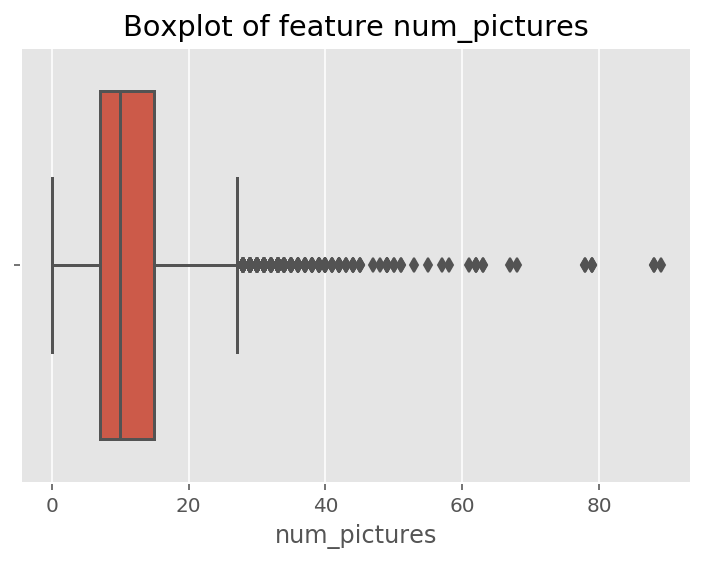

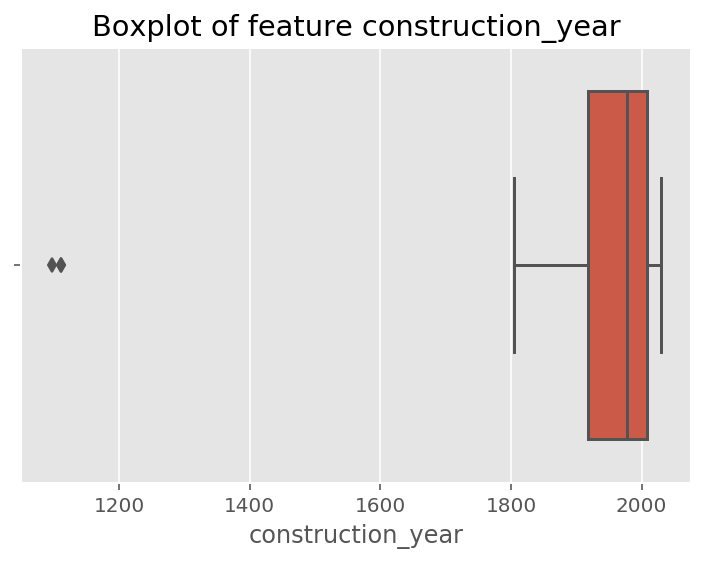

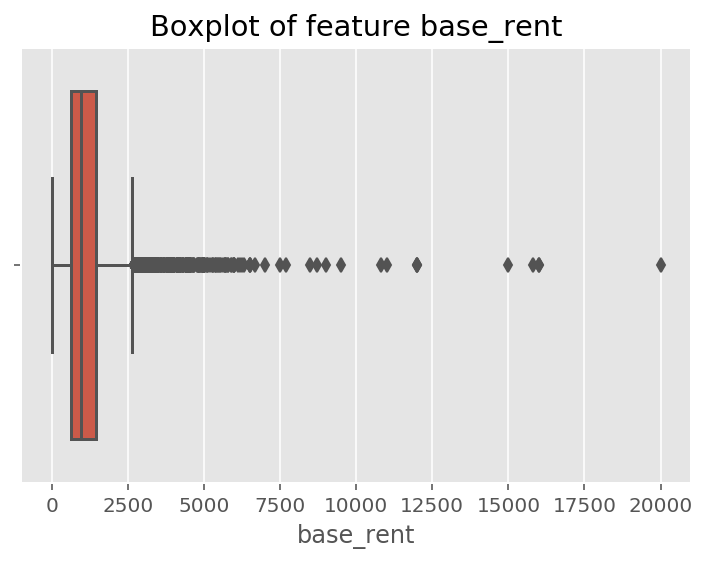

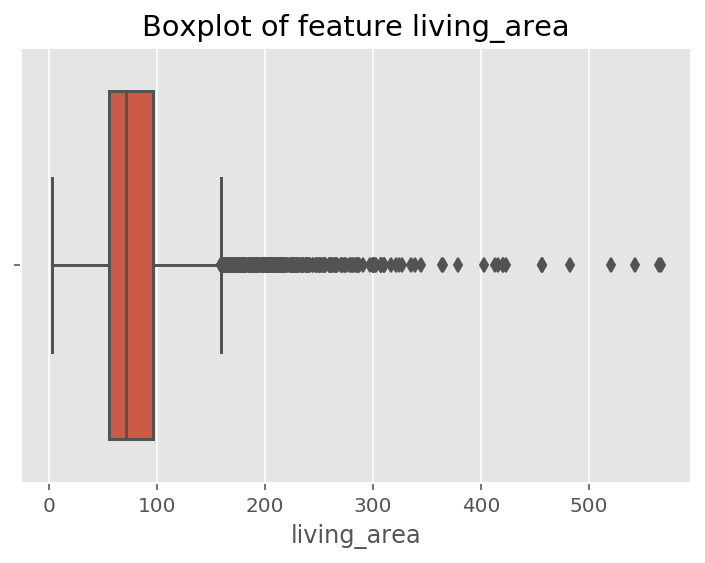

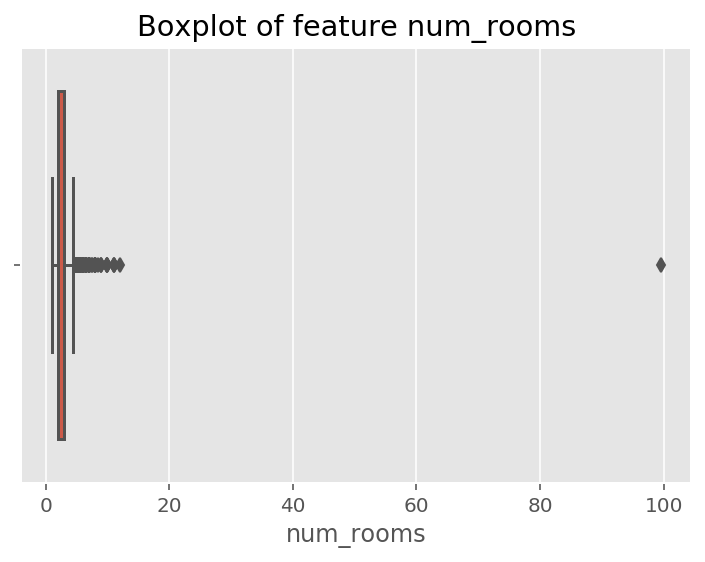

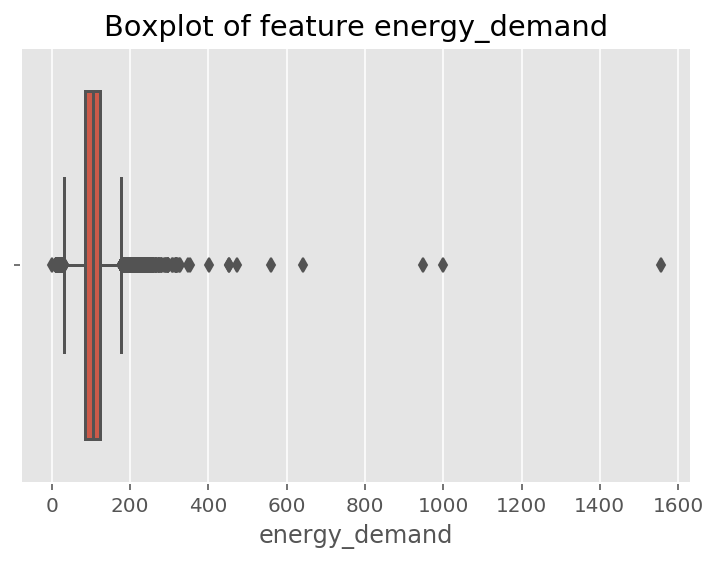

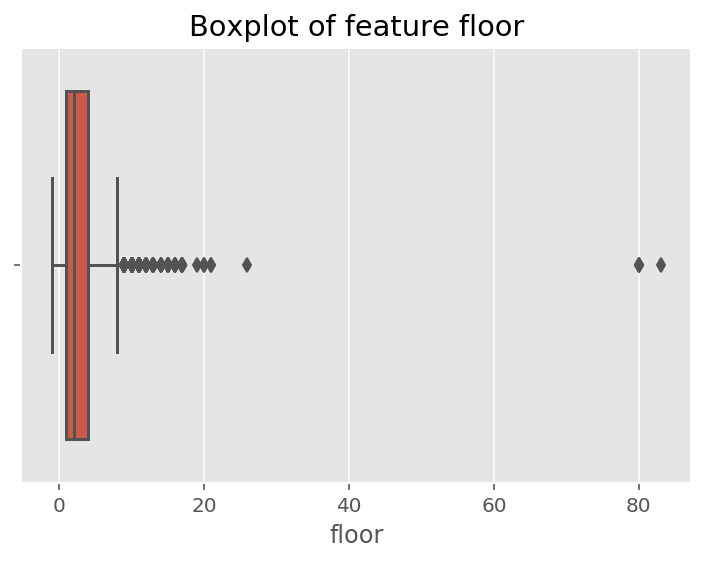

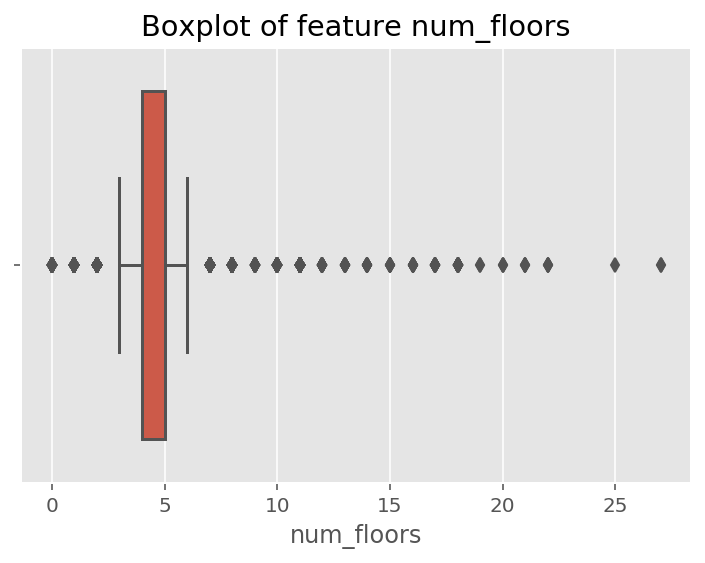

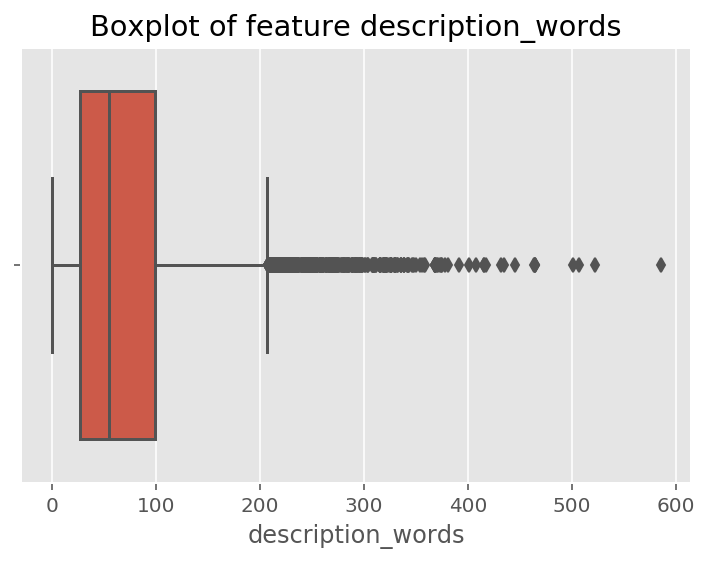

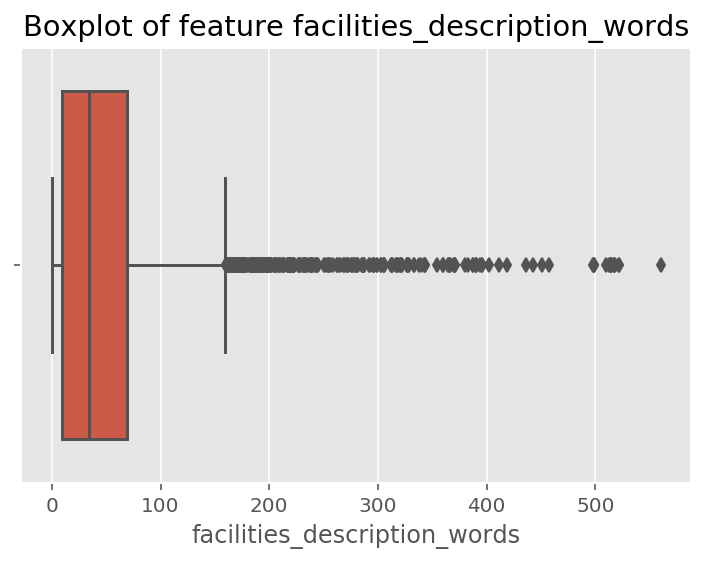

In [19]:
for col in continuous_cols:
        plt.title('Boxplot of feature ' + col)
        ax = sns.boxplot(rents[col])
        ax.set(xlabel=col)
        plt.show()

We can see that outliers are present in each feature. Let's clip this outliers before we continue with our data preparation and exploration.

In [20]:
rents['num_pictures'] = rents['num_pictures'].clip(upper=40)
rents['construction_year'] = rents['construction_year'].clip(lower=1800)
rents['base_rent'] = rents['base_rent'].clip(lower=150, upper=5000)
rents['living_area'] = rents['living_area'].clip(lower=7, upper=250)
rents['num_rooms'] = rents['num_rooms'].clip(lower=1, upper=15)
rents['energy_demand'] = rents['energy_demand'].clip(upper=300)
rents['floor'] = rents['floor'].clip(upper=15)
rents['num_floors'] = rents['num_floors'].clip(upper=15)

Let's have a look at the distribution of our target feature `base_rent` as this characteristic may have a high influence to the learning and performance of our machine learning model. Therefore, we visualize the distribution with the `distplot` function of `seaborn`.

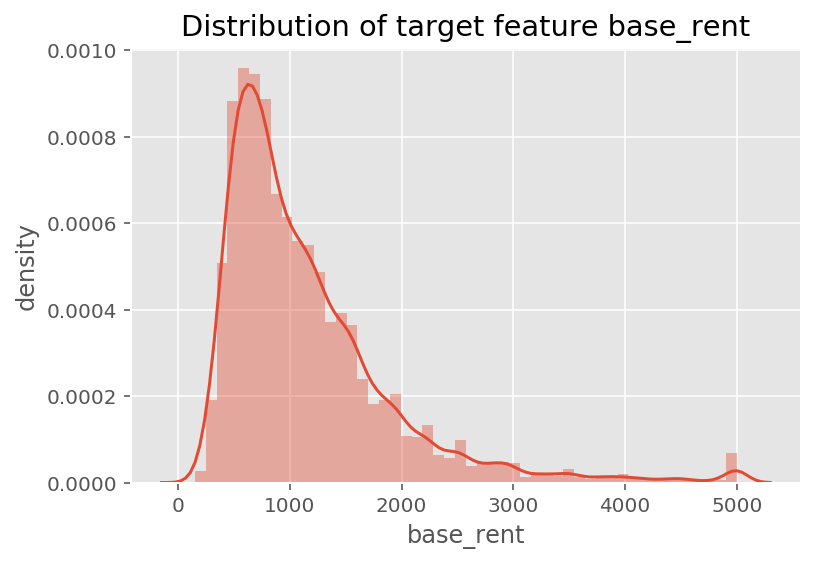

In [21]:
plt.title('Distribution of target feature base_rent')
ax = sns.distplot(rents['base_rent'])
ax.set(xlabel='base_rent', ylabel='density')
plt.show()

A lot of machine learning models assume the gaussian distribution (normal distribution) for the descriptive features and target feature. Since the target feature is heavily right skewed and doesn't follows a gaussian distribution, we can transform the target feature before performing the learning process of the machine learning model. In terms of the target feature `base_rent`, it is important to remind this transformation after the prediction. Otherwise, the results can be misinterpreted especially when we use the mean absolute error (MAE) for evaluation. For handling this issue, we can transform the prediction back using the inverse of the applied function. In this case, we can use the `log1p` from `numpy` as transformation function and `expm1` as the inverse function. We keep this in mind and perform it later before we train the machine learning model.

In the following, we want to explore the correlation between some descriptive features and the target feature. For example, the living area usually influences the base rent a lot since the rent is often calculated by the price per square meter mulitplied with the living area in square meter. Let's see if this assumption is true by visualizing the relationship with a scatter plot.

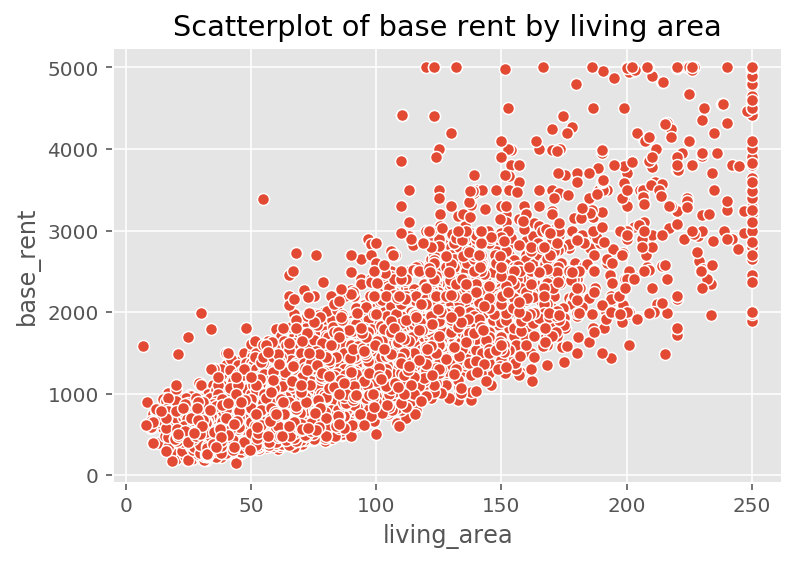

In [22]:
plt.title('Scatterplot of base rent by living area')
sns.scatterplot(rents['living_area'], rents['base_rent'])

In [23]:
print('Pearson’s correlation coefficient:', np.corrcoef(rents['living_area'], rents['base_rent'])[0, 1].round(3))

Pearson’s correlation coefficient: 0.838


The visualization and pearson's correlation coefficient supports the assumption that living area is a strong indicator for our target featur base rent. Let's do the same approach for the facilities description feature (word count).

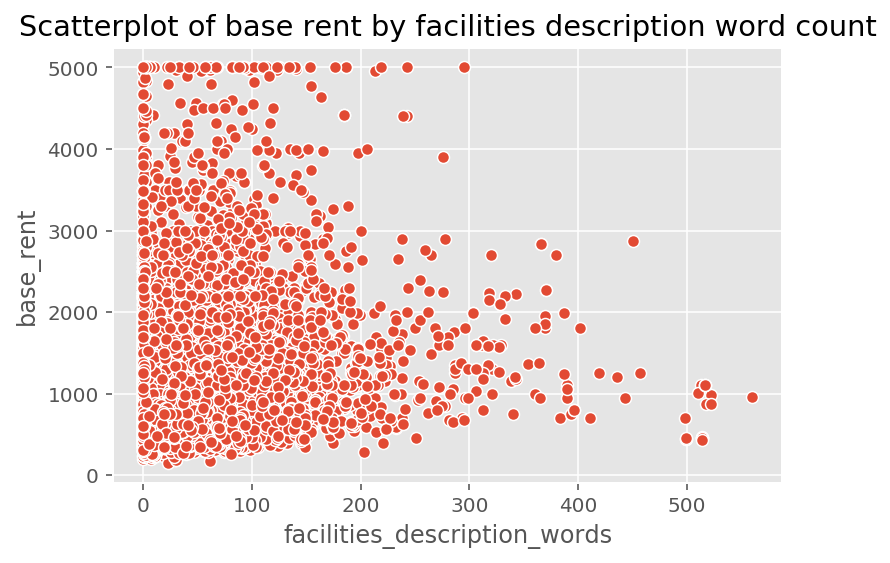

In [24]:
plt.title('Scatterplot of base rent by facilities description word count')
sns.scatterplot(rents['facilities_description_words'], rents['base_rent'])

In [25]:
print('Pearson’s correlation coefficient:', np.corrcoef(rents['facilities_description_words'], rents['base_rent'])[0, 1].round(3))

Pearson’s correlation coefficient: 0.127


We can conclude that this feature has not a strong correlation to the target feature base rent as the number of words apparently don't indicate the quality and availability of various facilities. Except only counting the words, we can process this unstructured data in another fashion such as filtering for special words. But this would be out of the scope of this project so we still use the word count for the machine learning model. In the following we can consider boolean features such as the availability of a kitchen or whether the building is new constructed.

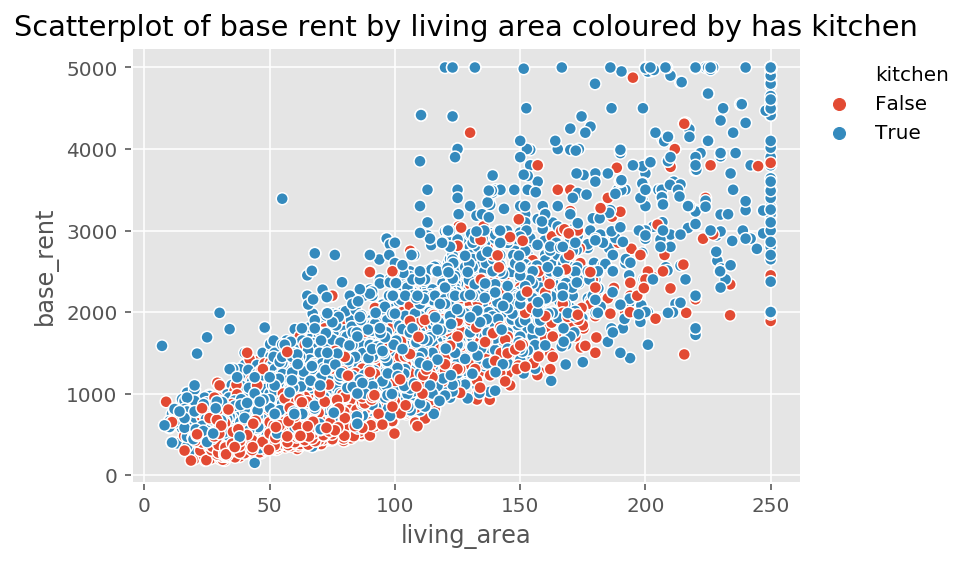

In [26]:
plt.title('Scatterplot of base rent by living area coloured by has kitchen')
sns.scatterplot(rents['living_area'], rents['base_rent'], hue=rents['kitchen'])

plt.legend(bbox_to_anchor=(1, 1), 
           facecolor="white", 
           frameon=False)

In [27]:
print('Base rent mean (kitchen=False):', round(rents.loc[rents['kitchen'] == False, 'base_rent'].mean(), 3))
print('Base rent mean (kitchen=True):', round(rents.loc[rents['kitchen'] == True, 'base_rent'].mean(), 3))

Base rent mean (kitchen=False): 879.956
Base rent mean (kitchen=True): 1339.049


Considering the mean base rent of the data with a kitchen and without a kitchen, we can conclude that expensive apartments mostly have a kitchen available.

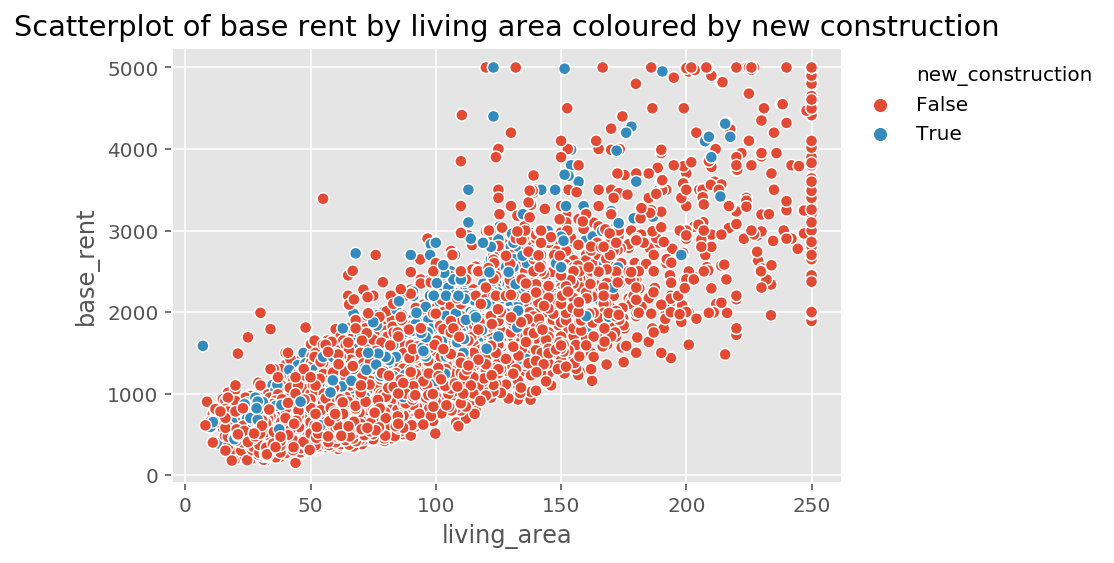

In [28]:
plt.title('Scatterplot of base rent by living area coloured by new construction')
sns.scatterplot(rents['living_area'], rents['base_rent'], hue=rents['new_construction'])

plt.legend(bbox_to_anchor=(1, 1), 
           facecolor="white", 
           frameon=False)

In [29]:
print('Base rent mean (new_construction=False):', round(rents.loc[rents['new_construction'] == False, 'base_rent'].mean(), 3))
print('Base rent mean (new_construction=True):', round(rents.loc[rents['new_construction'] == True, 'base_rent'].mean(), 3))

Base rent mean (new_construction=False): 1104.039
Base rent mean (new_construction=True): 1402.256


Considering the mean base rent of the data for old and new constructions, we can conclude that expensive apartments are mostly in new constructed building.

# Feature Engineering  <a id='feature_engineering'></a>

In this section, we want to create some new features by aggregating available raw features such as the living area and number of rooms. Furthermore, we can also include completly new features fetched from another data source. Let's build a descriptive feature `space_per_room` which represents the mean of the square meter per room.

In [30]:
rents['space_per_room'] = rents['living_area'] / rents['num_rooms']

[Text(0, 0.5, 'quantity')]

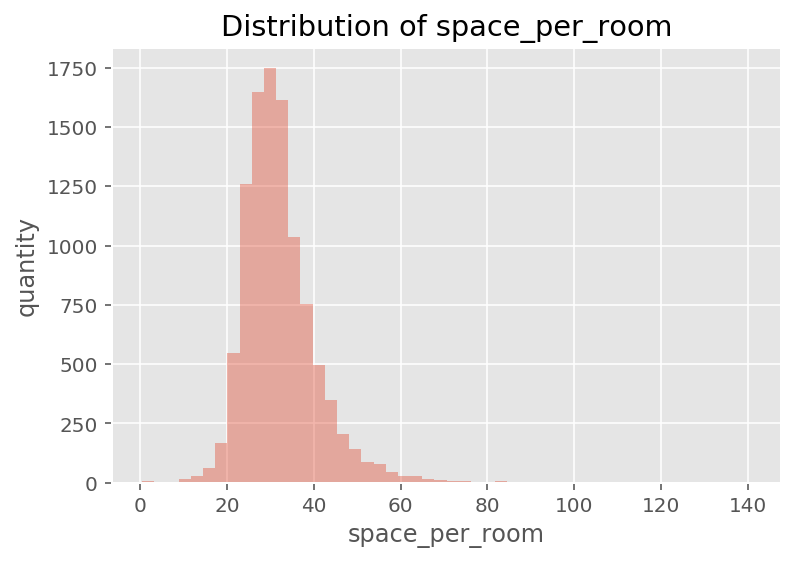

In [31]:
plt.title('Distribution of space_per_room')
ax = sns.distplot(rents['space_per_room'], kde=False)
ax.set(ylabel='quantity')

The distribution of the new feature `space_per_room` is obviously right skewed so we can clip the data to a defined upper border.

In [32]:
rents['space_per_room'] = rents['space_per_room'].clip(upper=80)

For reducing the dimensionality of the feature space, we can aggregate the categorical feature `condition` to a boolean feature  `good_condition` which represents whether the apartment is in a good or bad condition.

In [33]:
rents['good_condition'] = rents['condition']
rents.loc[rents['good_condition'].isin(['refurbished', 'first_time_use', 'mint_condition', 'modernized',
                                        'fully_renovated']), 'good_condition'] = True
rents.loc[rents['good_condition'] != True, 'good_condition'] = False
rents = rents.drop('condition', axis=1)

A common indicator for rent prices in specific areas such as the district of a city represents the rent index provided by the government. This index can positively contribute to the predictive power of our model. Therefore, we encode the city districts in an integer-encoding fashion. The low numbers represents a low rent price per square meter and high numbers a high rent price per square meter [3]:

- 0: < 6.50 $\frac{€}{sq meter}$
- 1: 6.50 - 7.50 $\frac{€}{sq meter}$
- 2: 7.51 - 8.50 $\frac{€}{sq meter}$
- 3: 8.51 - 9.50 $\frac{€}{sq meter}$
- 4: > 9.50 $\frac{€}{sq meter}$

In [34]:
district_index_mapping = {
'Staaken_Spandau': 0,
'Weißensee_Weißensee': 2,
'Mitte_Mitte': 4,
'Tiergarten_Tiergarten': 3,
'Grünau_Köpenick': 1,
'Köpenick_Köpenick': 1,
'Marzahn_Marzahn': 0,
'Neu_Hohenschönhausen_Hohenschönhausen': 0,
'Prenzlauer_Berg_Prenzlauer_Berg': 4,
'Hellersdorf_Hellersdorf': 0,
'Französisch_Buchholz_Pankow': 2,
'Charlottenburg_Charlottenburg': 3,
'Mariendorf_Tempelhof': 2,
'Neukölln_Neukölln': 3,
'Schmargendorf_Wilmersdorf': 3,
'Wedding_Wedding': 2,
'Siemensstadt_Spandau': 1,
'Britz_Neukölln': 3,
'Buch_Pankow': 2,
'Friedrichshain_Friedrichshain': 3,
'Karow_Weißensee': 2,
'Wilmersdorf_Wilmersdorf': 2,
'Reinickendorf_Reinickendorf': 1,
'Wittenau_Reinickendorf': 1,
'Schmöckwitz_Köpenick': 1,
'Spandau_Spandau': 1,
'Adlershof_Treptow': 1,
'Friedenau_Schöneberg': 3,
'Schöneberg_Schöneberg': 3,
'Alt_Hohenschönhausen_Hohenschönhausen': 2,
'Friedrichsfelde_Lichtenberg': 2,
'Karlshorst_Lichtenberg': 2,
'Lichtenberg_Lichtenberg': 2,
'Oberschöneweide_Köpenick': 1,
'Pankow_Pankow': 2,
'Johannisthal_Treptow': 1,
'Lichterfelde_Steglitz': 2,
'Konradshöhe_Reinickendorf': 1,
'Waidmannslust_Reinickendorf': 1,
'Heinersdorf_Weißensee': 2,
'Lichtenrade_Tempelhof': 2,
'Buckow_Neukölln': 1,
'Niederschöneweide_Treptow': 1,
'Zehlendorf_Zehlendorf': 2,
'Lankwitz_Steglitz': 2,
'Rosenthal_Pankow': 2,
'Biesdorf_Marzahn': 0,
'Marienfelde_Tempelhof': 2,
'Steglitz_Steglitz': 2,
'Dahlem_Zehlendorf': 2,
'Tempelhof_Tempelhof': 2,
'Treptow_Treptow': 1,
'Friedrichshagen_Köpenick': 2,
'Niederschönhausen_Pankow': 2,
'Mahlsdorf_Hellersdorf': 0,
'Hermsdorf_Reinickendorf': 1,
'Müggelheim_Köpenick': 1,
'Grunewald_Wilmersdorf': 4,
'Rahnsdorf_Köpenick': 1,
'Tegel_Reinickendorf': 2,
'Altglienicke_Treptow': 1,
'Baumschulenweg_Treptow': 1,
'Wannsee_Zehlendorf': 2,
'Frohnau_Reinickendorf': 1,
'Nikolassee_Zehlendorf': 2,
'Rudow_Neukölln': 2,
'Rummelsburg_Lichtenberg': 2,
'Haselhorst_Spandau': 1,
'Kladow_Spandau': 1,
'Bohnsdorf_Treptow': 1,
'Blankenburg_Weißensee': 2,
'Kaulsdorf_Hellersdorf': 0,
'Lübars_Reinickendorf': 1,
'Heiligensee_Reinickendorf': 1,
'Falkenberg_Hohenschönhausen': 0,
'Malchow_Hohenschönhausen': 0,
'Plänterwald_Treptow': 1,
'Gatow_Spandau': 1,
'Kreuzberg_Kreuzberg': 4}

In [35]:
rents['district_rent_index'] = rents['city_district'].replace(district_index_mapping)
rents = rents.drop('city_district', axis=1)

### Encoding Categorical Descriptive Features

As next step, we apply one-hot-encoding for the nominal categorical features and integer-encoding for the ordinal categorical features. If one-hot-encoding for a descriptive feature only includes a cardinality of 2, we use one column for keeping the dimensionality as low as possible. Furthermore, we drop the undefined feature columns for the different categorical features as this level contains less information about the base rent. The encoding is only applied on the descriptive features, therefore we divide the dataset into descriptive features and the target feature.

In [36]:
rents_sample = rents.sample(n=5000, random_state=seed)
Data = rents_sample.drop('base_rent', axis=1)
target = rents_sample['base_rent']

In [37]:
Data['interior_quality'] = Data['interior_quality'].replace({'simple': 0, 'normal': 1, 'sophisticated': 2, 'luxury': 3})

In [38]:
boolean_cols = Data.columns[Data.dtypes==bool].tolist()

for col in boolean_cols:
    Data[col].replace({True: 1, False: 0}, inplace=True)

In [39]:
categorical_cols = Data.columns[Data.dtypes==object].tolist()

for col in categorical_cols:
    n = len(Data[col].unique())
    if (n == 2):
        Data[col] = pd.get_dummies(Data[col], drop_first=True)

Data = pd.get_dummies(Data)

In [40]:
for col in Data.columns:
    if ('undefined' in col):
        Data.drop(col, axis=1, inplace=True)

After the encoding, our dataset consists of entirely 54 descriptive feature columns.

In [41]:
Data.shape

(5000, 54)

Lastly, let's have a look if the created features are of any importance for the prediction of the target feature. This can be done by using the `RandomForestRegressor`.

In [42]:
num_features = 10
model_rfi = RandomForestRegressor(n_estimators=100, random_state=seed)
model_rfi.fit(Data.values, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

best_features_rfi = Data.columns[fs_indices_rfi].values
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]

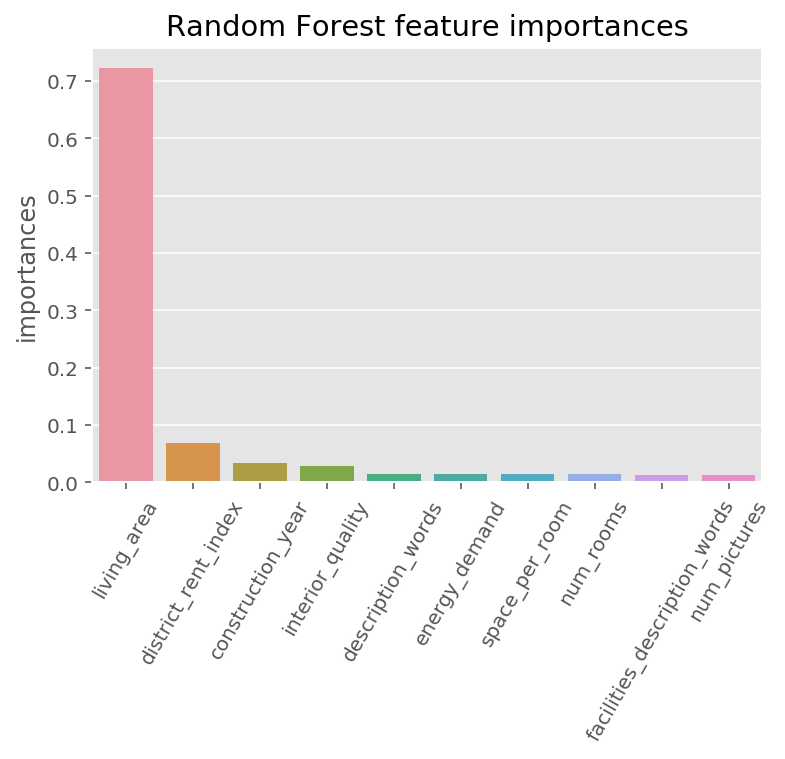

In [43]:
plt.title('Random Forest feature importances')
ax = sns.barplot(best_features_rfi, feature_importances_rfi)
ax.set(ylabel='importances')
for tick in ax.get_xticklabels():
    tick.set_rotation(60)

Obviously, the created features `district_rent_index` and `space_per_room`are at least in the top 10 features determined by the feature importances of the `RandomForestRegressor`. The living area is the most important descriptive feature for the estimation of the base rent.

# Modeling  <a id='modeling'></a>

### Preparation

As described in the section [Overview](#overview), the prepared dataset is split into a training and test dataset with the test ratio of 30%. The random sampling of a subset has been performed in the aforementioned subsection *Encoding Categorical Descriptive Features*. This results in the training dataset with 3500 observations and the test dataset with 1500 observations. In the following, three different regression models are tuned by the `KFold` and `GridSearchCV` techniques.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(Data.values, 
                                                    target, 
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=seed)

print(X_train.shape)
print(X_test.shape)

(3500, 54)
(1500, 54)


In [45]:
# Define the 5-fold cross-validation
cv_method = KFold(n_splits=5,
                  random_state=seed)

# Define the scoring method for GridSearchCV
scoring = 'neg_mean_absolute_error'

### Decision Tree (DT)

In the following, we use with decision trees an information-based approach and tuning the model considering the hyperparameters `criterion`, `max_depth` and `min_samples_split`. The class `DecisionTreeRegressor` is appropriate to predict continuous targets such as the `base_rent`.

In [46]:
%%capture
params_pipe_DT = {'selector__k': [3, 5, 10],
                  'model__regressor__criterion': ['mse', 'mae'],
                  'model__regressor__max_depth': [5, 10, 20, 30, 40, 50],
                  'model__regressor__min_samples_split': [30, 40, 50]}

model_DT = TransformedTargetRegressor(regressor=DecisionTreeRegressor(random_state=seed),
                                      func=np.log1p,
                                      inverse_func=np.expm1)

pipe_DT = Pipeline([('scaler', StandardScaler()),
                    ('selector', fs.SelectKBest(fs.mutual_info_regression)),
                    ('model', model_DT)])

gs_pipe_DT = GridSearchCV(estimator=pipe_DT, 
                           param_grid=params_pipe_DT, 
                           cv=cv_method,
                           scoring=scoring,
                           n_jobs=-2)

gs_pipe_DT.fit(X_test, y_test)

In [47]:
gs_pipe_DT.best_params_

{'model__regressor__criterion': 'mse',
 'model__regressor__max_depth': 20,
 'model__regressor__min_samples_split': 40,
 'selector__k': 5}

Let's have a look at the selected k best descriptive features.

In [48]:
dt_best_cols = gs_pipe_DT.best_estimator_.steps[1][1].get_support(indices=True)
Data.columns[dt_best_cols].tolist()

['num_pictures',
 'construction_year',
 'living_area',
 'num_rooms',
 'district_rent_index']

In [49]:
print('Decision Tree - MAE:', -gs_pipe_DT.best_score_.round(3))

Decision Tree - MAE: 231.3


In [50]:
results_DT  = get_search_results(gs_pipe_DT)
results_DT.head()

,mean_score,std_score,max_score,min_score,model__regressor__criterion,model__regressor__max_depth,model__regressor__min_samples_split,selector__k
22,-231.3,27.5121,-203.179,-283.163,mse,20,40,5
13,-231.703,27.338,-205.316,-283.678,mse,10,40,5
40,-231.728,27.0852,-205.316,-283.163,mse,40,40,5
76,-233.767,24.59,-203.897,-277.74,mae,20,40,5
103,-233.767,24.59,-203.897,-277.74,mae,50,40,5


The best parameters for our decision tree are mean squared error (mse) for the criterion, 20 for the maximum depth and 40 for the minimum split. The best MAE score of ~231 was reached with 5 features selected by `SelectKBest`. In the following, a visualization of the search results are given for 5 features and 40 minimum samples per split.

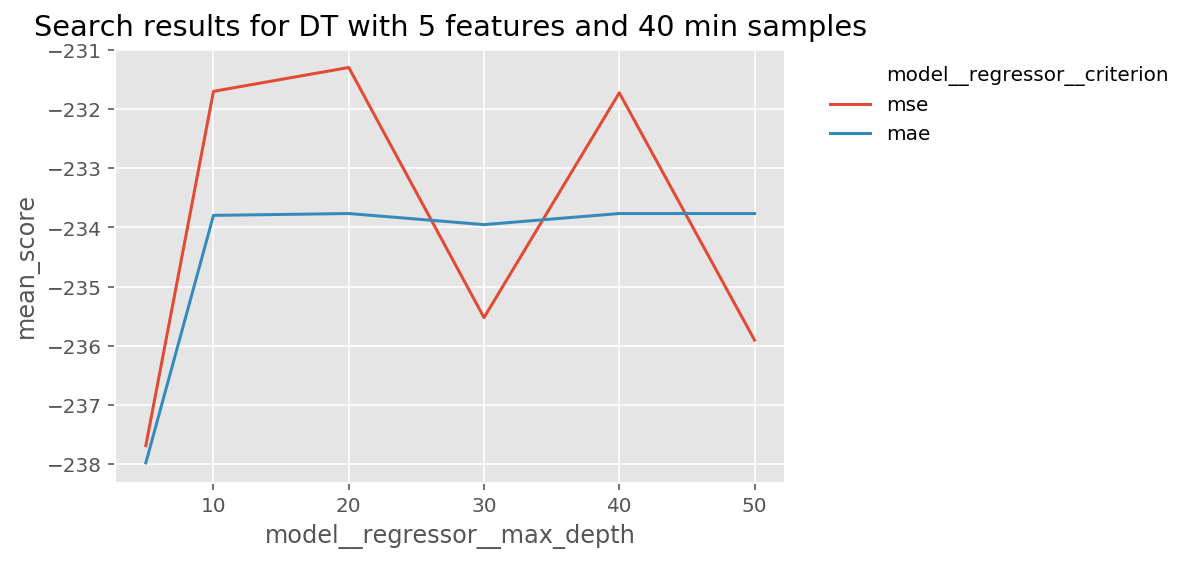

In [51]:
results_DT_5 = results_DT[(results_DT['selector__k'] == 5) & (results_DT['model__regressor__min_samples_split'] == 40)]
results_DT_5['model__regressor__max_depth'] = results_DT_5['model__regressor__max_depth'].astype(np.number)
results_DT_5['mean_score'] = results_DT_5['mean_score'].astype(np.number)

plt.title('Search results for DT with 5 features and 40 min samples')
sns.lineplot(x='model__regressor__max_depth', 
             y='mean_score', 
             hue='model__regressor__criterion',
             ci=None,
             data=results_DT_5)
plt.legend(bbox_to_anchor=(1.6, 1), 
           facecolor="white", 
           frameon=False)

### Support Vector Machine (SVR)

In the following, we use with support vector machines an error-based approach and tuning the model considering the hyperparameters `kernel` and `epsilon`. The class `SVR` is appropriate to predict continuous targets. Error-based machine learning models are often considered as a good choice for regression problems as in this project.

In [52]:
%%capture
params_pipe_SVR = {'selector__k': [20, 30, 40],
                   'model__regressor__kernel': ['linear', 'poly', 'rbf'],
                   'model__regressor__epsilon': 10.0 ** -np.arange(1, 7)}

model_SVR = TransformedTargetRegressor(regressor=SVR(),
                                      func=np.log1p,
                                      inverse_func=np.expm1)

pipe_SVR = Pipeline([('scaler', StandardScaler()),
                     ('selector', fs.SelectKBest(fs.mutual_info_regression)),
                     ('model', model_SVR)])

gs_pipe_SVR = GridSearchCV(estimator=pipe_SVR, 
                           param_grid=params_pipe_SVR, 
                           cv=cv_method,
                           scoring=scoring,
                           n_jobs=-2)

gs_pipe_SVR.fit(X_train, y_train)

In [53]:
gs_pipe_SVR.best_params_

{'model__regressor__epsilon': 1e-05,
 'model__regressor__kernel': 'rbf',
 'selector__k': 20}

Let's have a look at the selected k best descriptive features.

In [54]:
svr_best_cols = gs_pipe_SVR.best_estimator_.steps[1][1].get_support(indices=True)
Data.columns[svr_best_cols].tolist()

['new_construction',
 'balcony',
 'num_pictures',
 'construction_year',
 'kitchen',
 'living_area',
 'interior_quality',
 'elevator',
 'num_rooms',
 'energy_demand',
 'floor',
 'num_floors',
 'garden',
 'description_words',
 'facilities_description_words',
 'space_per_room',
 'good_condition',
 'district_rent_index',
 'heating_type_district_heating',
 'flat_type_apartment']

In [55]:
print('Support Vector Machine - MAE:', -gs_pipe_SVR.best_score_.round(3))

Support Vector Machine - MAE: 184.639


In [56]:
results_SVR  = get_search_results(gs_pipe_SVR)
results_SVR.head()

,mean_score,std_score,max_score,min_score,model__regressor__epsilon,model__regressor__kernel,selector__k
42,-184.639,1.18324,-182.44,-185.895,1e-05,rbf,20
33,-184.742,0.812576,-183.792,-186.037,0.0001,rbf,20
15,-185.919,2.92049,-182.521,-190.16,0.01,rbf,20
51,-186.126,7.16514,-178.787,-198.119,1e-06,rbf,20
34,-187.059,7.95247,-175.959,-198.757,0.0001,rbf,30


The best parameters for our support vector machine are rbf for the kernel and 0.00001 for epsilon. The best MAE score of ~184 was reached with 20 features selected by `SelectKBest`. In the following, a visualization of the search results are given for 20 features.

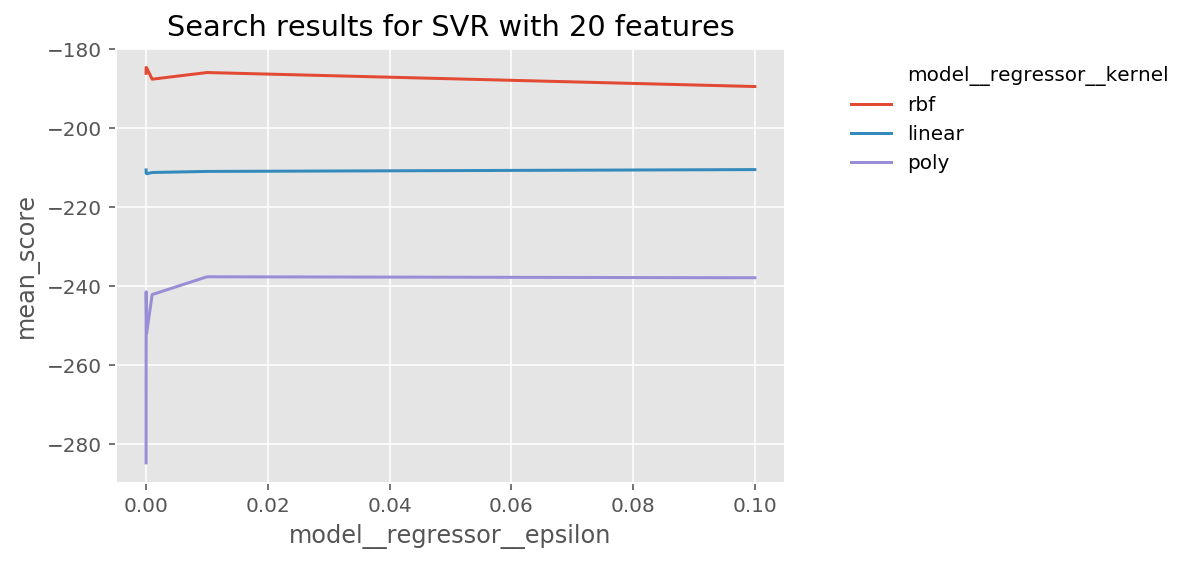

In [57]:
results_SVR_20 = results_SVR[results_SVR['selector__k'] == 20]
results_SVR_20['model__regressor__epsilon'] = results_SVR_20['model__regressor__epsilon'].astype(np.number)
results_SVR_20['mean_score'] = results_SVR_20['mean_score'].astype(np.number)

plt.title('Search results for SVR with 20 features')
sns.lineplot(x='model__regressor__epsilon', 
             y='mean_score', 
             hue='model__regressor__kernel',
             ci=None,
             data=results_SVR_20)
plt.legend(bbox_to_anchor=(1.6, 1), 
           facecolor="white", 
           frameon=False)

### Gradient Boosting (GB)

The gradient boosting approach represents an ensemble technique and combines multiple weak models to improve the estimation of our target feature by optimizing a suitable cost function. For the class `GradientBoostingRegressor`, we are tuning the model with the hyperparameters `n_estimators`, `max_depth` and `learning_rate`.

In [58]:
%%capture
params_pipe_GB = {'selector__k': [30, 40, X_train.shape[1]],
                  'model__regressor__n_estimators': [600, 800, 1000],
                  'model__regressor__max_depth': [1, 5, 10],
                  'model__regressor__learning_rate': [0.01, 0.05, 0.1]}

model_GB = TransformedTargetRegressor(regressor=GradientBoostingRegressor(random_state=seed),
                                      func=np.log1p,
                                      inverse_func=np.expm1)

pipe_GB = Pipeline([('scaler', StandardScaler()),
                    ('selector', fs.SelectKBest(fs.mutual_info_regression)),
                    ('model', model_GB)])

gs_pipe_GB = GridSearchCV(estimator=pipe_GB, 
                                param_grid=params_pipe_GB, 
                                cv=cv_method,
                                scoring=scoring,
                                n_jobs=-2)

gs_pipe_GB.fit(X_train, y_train)

In [59]:
gs_pipe_GB.best_params_

{'model__regressor__learning_rate': 0.05,
 'model__regressor__max_depth': 5,
 'model__regressor__n_estimators': 1000,
 'selector__k': 40}

Let's have a look at the selected k best descriptive features.

In [60]:
gb_best_cols = gs_pipe_GB.best_estimator_.steps[1][1].get_support(indices=True)
Data.columns[gb_best_cols].tolist()

['new_construction',
 'balcony',
 'num_pictures',
 'construction_year',
 'kitchen',
 'cellar',
 'living_area',
 'interior_quality',
 'elevator',
 'num_rooms',
 'energy_demand',
 'floor',
 'num_floors',
 'garden',
 'description_words',
 'facilities_description_words',
 'space_per_room',
 'good_condition',
 'district_rent_index',
 'heating_type_central_heating',
 'heating_type_combined_heat_and_power_plant',
 'heating_type_district_heating',
 'heating_type_floor_heating',
 'heating_type_gas_heating',
 'heating_type_heat_pump',
 'heating_type_night_storage_heater',
 'heating_type_self_contained_central_heating',
 'pets_negotiable',
 'pets_no',
 'flat_type_apartment',
 'flat_type_loft',
 'flat_type_maisonette',
 'flat_type_other',
 'flat_type_penthouse',
 'flat_type_roof_storey',
 'energy_efficiency_class_A',
 'energy_efficiency_class_B',
 'energy_efficiency_class_C',
 'energy_efficiency_class_E',
 'energy_efficiency_class_G']

In [61]:
print('Gradient Boosting - MAE:', -gs_pipe_GB.best_score_.round(3))

Gradient Boosting - MAE: 167.357


In [62]:
results_GB  = get_search_results(gs_pipe_GB)
results_GB.head()

,mean_score,std_score,max_score,min_score,model__regressor__learning_rate,model__regressor__max_depth,model__regressor__n_estimators,selector__k
43,-167.356770,5.641454,-157.324111,-173.568960,0.05,5.0,1000.0,40.0
36,-167.663767,4.872050,-159.675171,-173.611258,0.05,5.0,600.0,30.0
40,-168.815177,5.968495,-158.866491,-176.718813,0.05,5.0,800.0,40.0
38,-168.853367,5.470605,-160.890128,-175.532922,0.05,5.0,600.0,54.0
39,-168.939508,5.866674,-159.765494,-176.211185,0.05,5.0,800.0,30.0


The best parameters for our gradient boosting model are 0.05 for the learning rate, 5 for the maximum depth and 1000 for the estimators. The best MAE score of ~168 was reached with the best 40 features selected by `SelectKBest`. In the following, a visualization of the search results are given for 40 features and 5 for maximum depth.

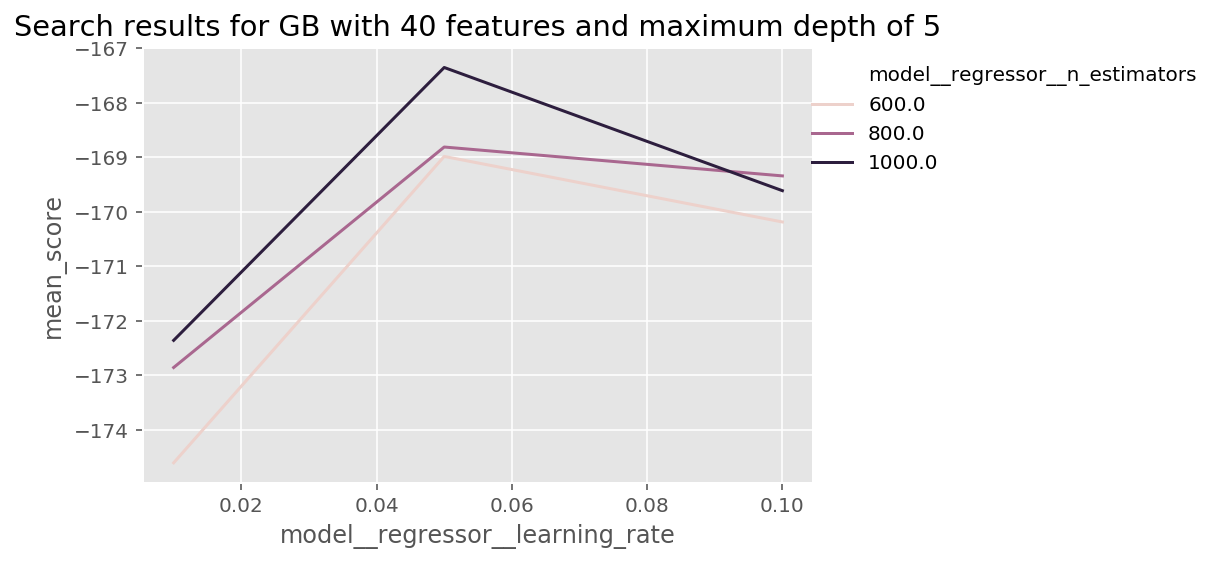

In [63]:
results_GB_40 = results_GB[(results_GB['selector__k'] == 40) & (results_GB['model__regressor__max_depth'] == 5)]
results_GB_40['model__regressor__learning_rate'] = results_GB_40['model__regressor__learning_rate'].astype(np.number)
results_GB_40['mean_score'] = results_GB_40['mean_score'].astype(np.number)

plt.title('Search results for GB with 40 features and maximum depth of 5')
sns.lineplot(x='model__regressor__learning_rate', 
             y='mean_score', 
             hue='model__regressor__n_estimators',
             ci=None,
             legend='full',
             data=results_GB_40)
plt.legend(bbox_to_anchor=(1.6, 1), 
           facecolor="white", 
           frameon=False)

We can conclude that the amount of estimators improves the performance of the gradient boosting model by using the negative mean absolute error as scoring. Since the searchspace ends at 1000 estimators, we could try to increase the number of estimators to improve our model. However, this would also increase the required time for learning hence we don't run the model with more estimators.

# Evaluation  <a id='evaluation'></a>

In the section [Modeling](#modeling), we figured out the best hyperparameters of the considered three models `DecisionTreeRegressor`, `SVR` and `GradientBoostingRegressor` by tuning the model with using grid search and 5-fold cross-validation. The best MAE score was accomplished by the gradient boosting technique and received ~169 mean absolute error. Therefore, the model used 40 descriptive features which were selected by the select k best technique with mutual information.

In the following, we compare the perfromances of the tuned regression models by fitting each model on the test dataset in 10-fold cross-validation fashion to figure out which regression model estimates the target feature `base_rent` best. For each model, the best k features are used whereby k is determined by the results of the model tuning part. As cross-validation reprents a random process, we use paired t-tests to identify the statistically significance of the performance differences [2].

In [64]:
cv_method_ttest = KFold(n_splits=10,
                        random_state=seed)

In [65]:
cv_results_DT = cross_val_score(estimator=gs_pipe_DT.best_estimator_,
                                X=X_test,
                                y=y_test,
                                cv=cv_method_ttest,
                                scoring=scoring,
                                n_jobs=-2)

In [66]:
print('Decision Tree - MAE:', -cv_results_DT.mean().round(3))

Decision Tree - MAE: 235.97


In [67]:
cv_results_SVR = cross_val_score(estimator=gs_pipe_SVR.best_estimator_,
                                 X=X_test,
                                 y=y_test,
                                 cv=cv_method_ttest,
                                 scoring=scoring,
                                 n_jobs=-2)

In [68]:
print('Support Vector Machine - MAE:', -cv_results_SVR.mean().round(3))

Support Vector Machine - MAE: 198.511


In [69]:
cv_results_GB = cross_val_score(estimator=gs_pipe_GB.best_estimator_,
                                 X=X_test,
                                 y=y_test,
                                 cv=cv_method_ttest,
                                 scoring=scoring,
                                 n_jobs=-2)

In [70]:
print('Gradient Boosting - MAE:', -cv_results_GB.mean().round(3))

Gradient Boosting - MAE: 187.199


We are comparing the models with the following combinations:

- DT vs SVR
- DT vs GB
- SVR vs GB

In [71]:
ttest_df = pd.DataFrame(columns=['estimator_1', 'estimator_2', 'p_value'])
ttest_df.loc[len(ttest_df)] = ['DT', 'SVR', stats.ttest_rel(cv_results_DT, cv_results_SVR).pvalue]
ttest_df.loc[len(ttest_df)] = ['DT', 'GB', stats.ttest_rel(cv_results_DT, cv_results_GB).pvalue]
ttest_df.loc[len(ttest_df)] = ['SVR', 'GB', stats.ttest_rel(cv_results_SVR, cv_results_GB).pvalue]

In [72]:
ttest_df

,estimator_1,estimator_2,p_value
0,DT,SVR,0.000502
1,DT,GB,0.000037
2,SVR,GB,0.045589


A p-value smaller than 0.05 indicates a statistically significant difference. Therefore, we can conclude that the gradient boosting regressor is statistically the best model in this comparison using the MAE score.

In [73]:
results = pd.DataFrame([[-cv_results_DT.mean().round(3), -cv_results_SVR.mean().round(3), -cv_results_GB.mean().round(3)]], 
                       columns=['Decision Tree', 'Support Vector Machine', 'Gradient Boosting'], index=['MAE'])

# Limitations  <a id='limitations'></a>

Throughout this project, we compared different regression techniques for the estimation of base rents in the capital city of Germany. However, the presented methodology has some drawbacks and limitations. First of all, we only used a small subset of the full dataset for learning and comparing the machine learning models. Using a larger training dataset can result into a lower mean absolute error since the used 3500 and 1500 observations poses a rather small dataset in terms of machine learning. Moreover, we only considered the state Berlin of the entire dataset. The usage of all states lead to a larger dataset and could contribute to a better generalization of the data by our models.

Secondly, the feature importances of the random forest regression have shown that the descriptive feature `living_area` carries the most information by far of all 54 featues. Hence, spending more time into the steps data preprocessing, data exploration and feature engineering can reveal information for creating more meaningful descriptive features. For example, the comprehend analysis and preprocessing of unstructured data such as the `description` may improve the performances of our regression models.

Lastly, for the sake of clarity we removed the `date` as a time component. Since the rent prices are usually increasing over time, considering this time component could lead to more accurate prediction results. Therefore, we could preprocess and include the date of the observation to reduce the error of the predictions.

# Summary  <a id='summary'></a>

The gradient boosting regressor produces the best mean absolute error and outperformed the decision tree and support vector machine models both for the training and test dataset. Thereby, the optimal gradient boosting model used the best 40 descriptive features selected by the k-best approach with mutual information. The optimal hyperparameters were `learning_rate = 0.05`, `max_depth = 5` and `n_estimators = 1000`. However, the amount of estimators leads to a high training time as 1000 weak models must be fit for applying this ensemble approach. Furthermore, we observed that all models are producing the best results with less descriptive features than available which confirms the feature importances determined by the random forest regression. The transformation of the feature distributions into normal distributions was only applied on the target feature `base_rent`. As further work, the investigation and transformation of descriptive feature distributions can be applied to reach a lower mean absolute error. Lastly, the aforementioned methodology limitations should be taken into account.

In [74]:
results

,Decision Tree,Support Vector Machine,Gradient Boosting
MAE,235.97,198.511,187.199


In this project, we followed the objective to predict the monthly rent prices of real estate objects in the capital city of Germany. As next step, it is necessary to deploy the trained model (gradient boosting regressor), integrate it into an application (e.g. real estate platform) and to apply a monitoring approach such as calculating the stability index based on the feature distributions.

# References  <a id='references'></a>

[1] "Apartment rental offers in Germany", Kaggle.com, 2020. [Online]. Available: https://www.kaggle.com/corrieaar/apartment-rental-offers-in-germany. [Accessed: 25- May- 2020].

[2] V. Aksakalli, "Case Study: Predicting Income Status", www.featureranking.com, 2020. [Online]. Available: https://www.featureranking.com/tutorials/machine-learning-tutorials/case-study-predicting-income-status/. [Accessed: 25- May- 2020].

[3] "Mietspiegel Berlin - Immobilienpreise & Markttrends", Immobilienscout24.de, 2020. [Online]. Available: https://www.immobilienscout24.de/immobilienbewertung/ratgeber/mietpreise-und-kaufpreise/mietspiegel/mietspiegel-berlin.html. [Accessed: 25- May- 2020].